### Abstract

We are interested to understand how people adjust their behaviour to the underlying temporal structure of changes. For this purpose we have modified a standard reversal learning task to include exploratory (epistemic) choices, which participants can use to learn the correct choice on the current trial. Participants were separated in two groups, each group exposed to different experimental conditions characterised by a different temporal structure of reversals.

In the first condition participants were exposed to regular (predictable) reversals for 800 trials and then to irregular sequence of reversals for 200 trials (same reversal rate but les predictable moment of reversals). In the second condition, the participant were first exposed to the irregular reversals (for 800 trials) and then to a sequence of regular reversal 200 trials.

Quanitfying probability of exploratory choices at each trial relative to the moment of reversals we can identify distinct characteristic responses of behaviour in two experimental conditions. This results suggest that people are sensitive to the temporal structure of the reversals (they can learn it) and that they use this structure for infering most likely moments of reversals, as reflected in the statistics of exploratory choices.

In [1]:
# load behavioural data
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(context='talk', style = 'white', color_codes = True)
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

df_res = pd.read_csv('pilot/responses.csv').set_index('subject')
responses = df_res.values[:, :-2].T.astype(float)

outcomes = pd.read_csv('pilot/outcomes.csv').set_index('subject').values.T.astype(float)
corrects = pd.read_csv('pilot/correct_responses.csv').set_index('subject').values.T.astype(float)

states_and_rewards = io.loadmat('pilot/states_and_rewards.mat')
Sirr = states_and_rewards['irregular']['S'][0, 0][:, 0] - 1
Oirr = states_and_rewards['irregular']['R'][0, 0]
Sreg = states_and_rewards['regular']['S'][0, 0][:, 0] - 1
Oreg = states_and_rewards['regular']['R'][0, 0]

ns_reg = (df_res['condition'] == 'regular').sum()   # number of subjects in the regular reversals group
ns_irr = (df_res['condition'] == 'irregular').sum()  # number of subjects in the irregular reversals group

nsub = responses.shape[-1]

In [2]:
# remove subjects which did not generate exploratory responses
expl_subs = (responses == 2).sum(0) > 20
expl_sub_num = np.arange(nsub)[expl_subs]
nexpl_sub_num = np.arange(nsub)[~expl_subs]

reg_res = responses[..., expl_sub_num[expl_sub_num < ns_reg]]
irr_res = responses[..., expl_sub_num[expl_sub_num >= ns_reg]]

reg_corr = corrects[..., expl_sub_num[expl_sub_num < ns_reg]]
irr_corr = corrects[..., expl_sub_num[expl_sub_num >= ns_reg]]

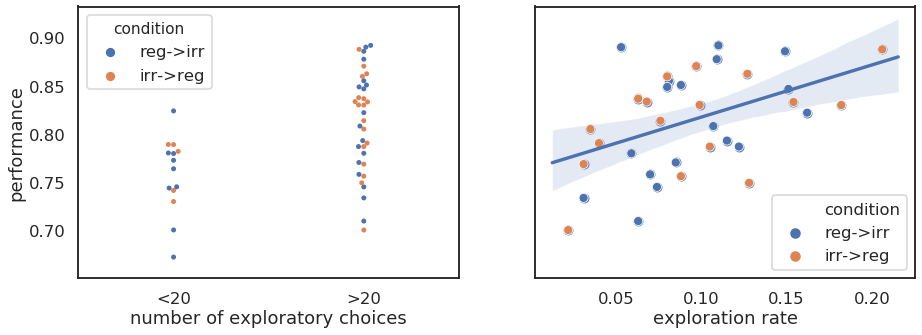

In [3]:
df = pd.DataFrame({'performance': np.nanmean(corrects, -2)})

df['exploration'] = np.sum(responses == 2, -2)/1000.

df['hints'] = '<20'
df.loc[expl_sub_num, 'hints'] = '>20'

df['condition'] = 'reg->irr'
df.loc[ns_reg:, 'condition'] = 'irr->reg'

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.swarmplot(x='hints', y='performance', data=df, hue='condition', ax=axes[0]);
sns.regplot(x='exploration', y='performance', data=df.loc[df.hints == '>20'], ax=axes[1]);
sns.scatterplot(x='exploration', 
                y='performance', 
                data=df.loc[df.hints == '>20'], 
                ax=axes[1], hue='condition');

axes[0].set_xlabel('number of exploratory choices')
axes[1].set_xlabel('exploration rate')
fig.savefig('Fig3.pdf', bbox_inches='tight', transparent=True, dpi=300)

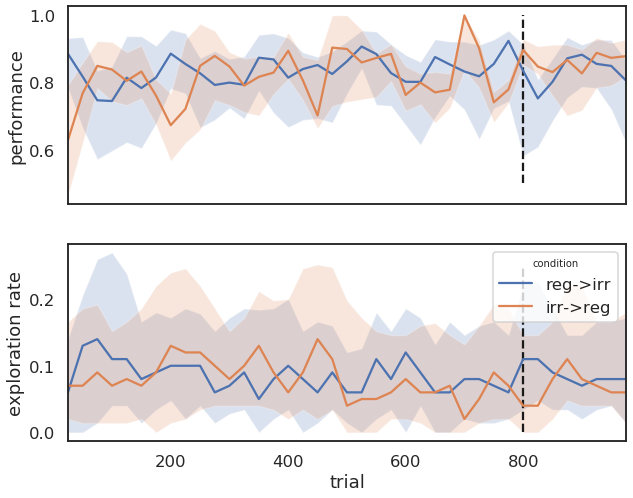

In [4]:
D = 25
m1 = []
m2 = []
exp1 = reg_res == 2
exp2 = irr_res == 2
e1 = []
e2 = []
for t in range(D, 1000 - D + 1, D):
    e1.append(np.nanmean(exp1[t-D:t+D], -2))
    e2.append(np.nanmean(exp2[t-D:t+D], -2))
    m1.append(np.nanmean(reg_corr[t-D:t+D], -2))
    m2.append(np.nanmean(irr_corr[t-D:t+D], -2))

m1 = np.vstack(m1)
p1 = np.percentile(m1, [10, 50, 90], -1)

m2 = np.vstack(m2)
p2 = np.percentile(m2, [10, 50, 90], -1)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

x = list(range(D, 1000 - D + 1, D))
axes[0].plot(x, p1[1], label='reg->irr');
axes[0].fill_between(x, p1[0], p1[-1], alpha=.2);

axes[0].plot(x, p2[1], label='irr->reg');
axes[0].fill_between(x, p2[0], p2[-1], alpha=.2);
axes[0].vlines(800, .5, 1, 'k', linestyle='--')

axes[1].set_xlim([D, 1000-D])

e1 = np.vstack(e1)
p1 = np.percentile(e1, [10, 50, 90], -1)

e2 = np.vstack(e2)
p2 = np.percentile(e2, [10, 50, 90], -1)

axes[1].plot(x, p1[1], label='reg->irr');
axes[1].fill_between(x, p1[0], p1[-1], alpha=.2);

axes[1].plot(x, p2[1], label='irr->reg');
axes[1].fill_between(x, p2[0], p2[-1], alpha=.2);

axes[1].vlines(800, .0, .25, 'k', linestyle='--')

axes[0].set_ylabel('performance');
axes[1].set_ylabel('exploration rate')
axes[1].set_xlabel('trial');

axes[1].legend(loc=0, title='condition');

fig.savefig('Fig4.pdf', bbox_inches='tight', transparent=True, dpi=300)

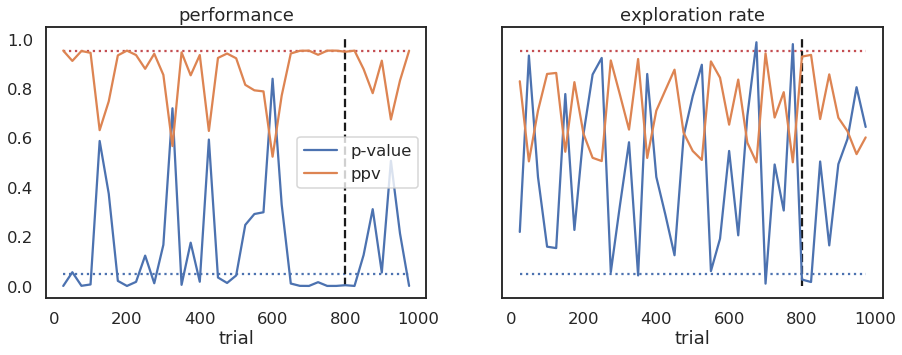

In [5]:
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.diagnostic import kstest_normal

c = .999
ln_m1 = np.log(c*m1/(1 - c*m1))
ln_m2 = np.log(c*m2/(1 - c*m2))

ln_e1 = np.log((c*e1 + 1e-3)/(1 - c*e1 - 1e-3))
ln_e2 = np.log((c*e2 + 1e-3)/(1 - c*e2-1e-3))

n1 = m1.shape[-1]
n2 = m2.shape[-1]
ratio = n2 / n1
alpha = .05

effect_size = []
p_values = []
power = []
normality = []

for i in range(len(x)):
    tstat, pvalue1, df = ttest_ind(ln_m1[i], ln_m2[i], alternative='two-sided', usevar='unequal')
    tstat, pvalue2, df = ttest_ind(ln_e1[i], ln_e2[i], alternative='two-sided', usevar='unequal')
    p_values.append([pvalue1, pvalue2])
    effs1 = np.abs(ln_m1[i].mean() - ln_m2[i].mean())/\
        np.sqrt(((n1-1)*ln_m1[i].var() + (n2 - 1)*ln_m2[i].var())/(n1 + n2 - 2))
    effs2 = np.abs(ln_e1[i].mean() - ln_e2[i].mean())/\
        np.sqrt(((n1-1)*ln_e1[i].var() + (n2 - 1)*ln_e2[i].var())/(n1 + n2 - 2))
    effect_size.append([effs1, effs2])
    power.append([tt_ind_solve_power(effs1, nobs1=n1, ratio=ratio, alpha=alpha),
                 tt_ind_solve_power(effs2, nobs1=n1, ratio=ratio, alpha=alpha),])

effect_size = np.array(effect_size)
power = np.array(power)
p_values = np.array(p_values)
ppv = power/(power + alpha)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
for i in range(2):
    axes[i].plot(x, p_values[:, i], label='p-value')
    axes[i].plot(x, ppv[:, i], label='ppv')
    axes[i].hlines(alpha, D, 1000-D, 'b', linestyle=':')
    axes[i].hlines(1-alpha, D, 1000-D, 'r', linestyle=':')
    axes[i].vlines(800, 0, 1, 'k', linestyle='--')

axes[0].legend();
axes[0].set_title('performance');
axes[1].set_title('exploration rate');
axes[0].set_xlabel('trial')
axes[1].set_xlabel('trial')

fig.savefig('sup_Fig3.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [6]:
trials = 1000
def get_reversal_statistics(responses, corrects, states, nsub, delta=200):

    A = responses.T == 2
    C = corrects.T

    reversal = np.abs(np.diff(states.flatten())).astype(bool)
    trials = np.arange(1, 1000)[reversal]
    perf = {}
    expl = {}
    for t in trials:
        block = np.long(np.floor(t/delta))
        perf.setdefault(block, [])
        perf[block].append(np.nanmean(C[:,t-10:t+10], 0))
        
        expl.setdefault(block, [])
        expl[block].append(np.nanmean(A[:,t-10:t+10], 0))
    
    return perf, expl

In [19]:
nsub = reg_res.shape[-1]
reg_perf, reg_expl = get_reversal_statistics(reg_res, reg_corr, Sreg, nsub)

nsub = irr_res.shape[-1]
irr_perf, irr_expl = get_reversal_statistics(irr_res, irr_corr, Sirr, nsub)

t = np.arange(-10, 10)

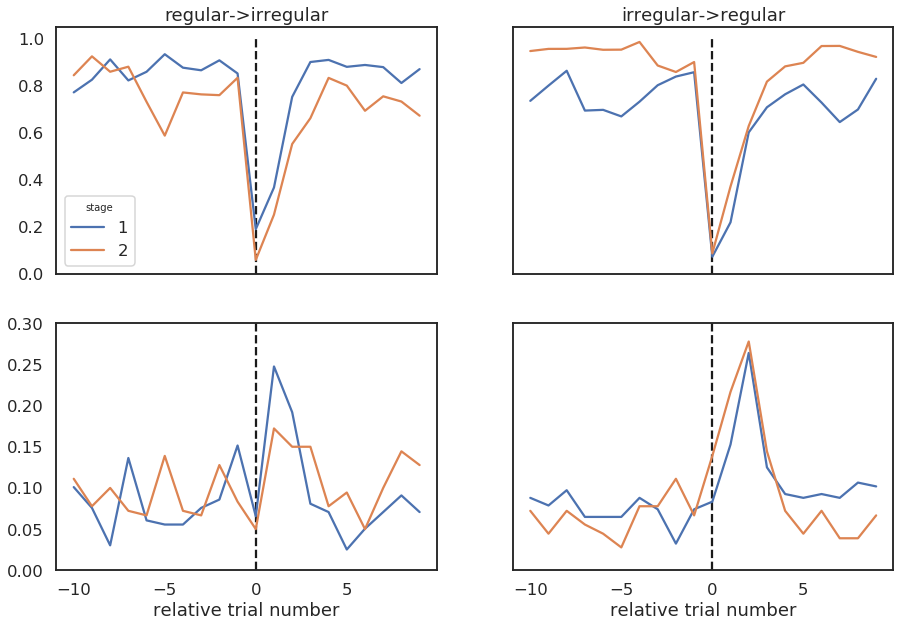

In [8]:
# plot mean probability of making a correct choice (exploitative) relative to the trial number

fig, axes = plt.subplots(2, 2, figsize=(15,10), sharex=True)
labels = {4:1, 5:2}
for block in range(3, 5):
    axes[0, 1].plot(t, np.mean(np.vstack(irr_perf[block]), 0))
    axes[0, 0].plot(t, np.mean(np.vstack(reg_perf[block]), 0), label=labels[block+1])
    axes[1, 0].plot(t, np.mean(np.vstack(reg_expl[block]), 0))
    axes[1, 1].plot(t, np.mean(np.vstack(irr_expl[block]), 0))

axes[0, 0].set_ylim([0, 1.05]);
axes[0, 1].set_ylim([0, 1.05]);
axes[1, 0].set_ylim([0, .3]);
axes[1, 1].set_ylim([0, .3]);

# axes[0].legend(title='stage');
axes[0, 0].vlines(0, 0., 1., 'k', linestyle='--');
axes[0, 1].vlines(0, 0., 1., 'k', linestyle='--');
axes[1, 0].vlines(0, 0., 3., 'k', linestyle='--');
axes[1, 1].vlines(0, 0., 3., 'k', linestyle='--');

axes[1, 1].set_xlabel('relative trial number');
axes[1, 0].set_xlabel('relative trial number');
axes[0, 0].set_title('regular->irregular');
axes[0, 1].set_title('irregular->regular');

axes[0, 1].set_yticklabels('');
axes[1, 1].set_yticklabels('');

axes[0, 0].legend(title='stage')

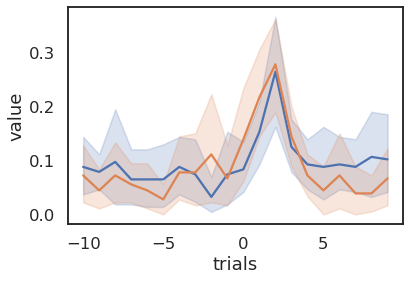

In [9]:
df1 = pd.DataFrame(np.vstack(irr_expl[3]).T)
df1['trials'] = t

df1 = df1.melt(id_vars='trials')
sns.lineplot(x='trials', y='value', data = df1)

df1 = pd.DataFrame(np.vstack(irr_expl[4]).T)
df1['trials'] = t

df1 = df1.melt(id_vars='trials')
sns.lineplot(x='trials', y='value', data = df1)

# Simulated data

mean =  tensor(20.3382)
mean =  tensor(20.6580)
mean =  tensor(19.4488)


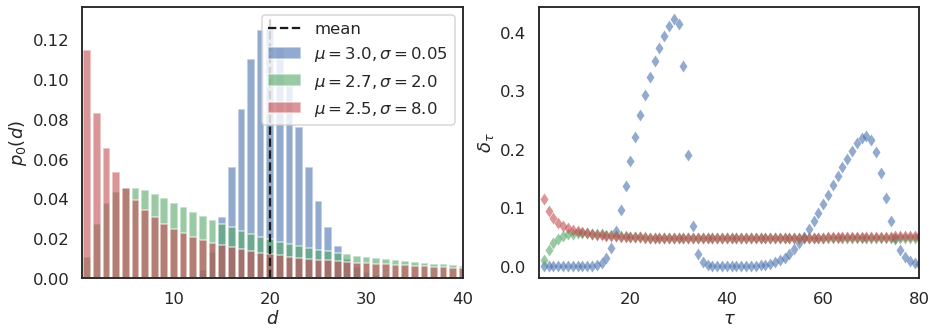

In [10]:
import torch

def evolve_change_prob(S, D, T):
    # joint transition matrix
    tm=torch.einsum('ijk,lk->iljk', S, D)
    
    #change probability
    dlt_tau = torch.zeros(T-1)
    
    #joint_probability if the previous state was non reversal 
    #and the previous state duration follows the prior p0(d)
    joint = torch.einsum('ijkl,l->ijk', tm, D[:,0])[:,:,0]
    
    #estimate change probability delta_tau at a future trial tau
    for tau in range(T-1):
        marg_prob = joint.sum(1)
        if tau == 0:
            dlt_tau[tau] = marg_prob[1]
        else:
            dlt_tau[tau] = marg_prob[1,0]/marg_prob[:,0].sum(0)
            joint = joint.sum(-1)
        
        joint = torch.einsum('ijkl,kl->ijk', tm, joint)
    
    return dlt_tau

d_max = 100 #maximal interval duration
d = torch.arange(1., d_max+1., 1.)

ds = 2
R = (torch.ones(ds,ds) - torch.eye(ds))/(ds-1)
S = torch.zeros(ds,ds,d_max)
S[:,:,0] = R
S[:,:,1:] = torch.eye(ds).reshape(ds, ds, 1)

D = torch.zeros(d_max, d_max)
for k in range(1,d_max):
    D[k-1, k] = 1 

fig, ax = plt.subplots(1, 2, figsize = (15,5))

mu = 20
color = ['b', 'g', 'r']
labels = [r'$\sigma = \mu$', r'$\sigma = 10\mu$', r'$\sigma = (\mu-1)\mu$']
for i, mu, sig in zip(range(3), torch.tensor([3, 2.7, 2.5]), torch.tensor([.05, 2, 8])):
    p0 = torch.softmax(-(d.log()-mu)**2/sig - d.log(), -1)
    print('mean = ', torch.sum(d*p0))
    D[:,0] = p0
    ax[0].bar(np.arange(d_max)+1, p0.numpy(), alpha = 0.6, label = r'$\mu={:.2}, \sigma={:.2}$'.format(mu, sig), color=color[i])
    T = 100
    ax[1].plot(np.arange(2, T+1, 1), evolve_change_prob(S, D, T).numpy(), 'd', alpha=.6, 
               label =labels[i], color=color[i], markeredgecolor='none')

ax[0].vlines(20, 0, .13, 'k', linestyle='--', label='mean')
ax[0].legend()
ax[0].set_xlim([.5,40])
ax[0].set_xlabel('$d$')
ax[0].set_ylabel('$p_0(d)$')

ax[1].set_ylabel(r'$\delta_{\tau}$')
ax[1].set_xlabel(r'$\tau$')
ax[1].set_xlim([1,80])

fig.savefig('distribution.svg', bbox_inches='tight', transparent=True, dpi=300)

tensor(20.7767) tensor(20.0000)
tensor(20.6713) tensor(19.9730)
tensor(19.4343) tensor(19.8258)


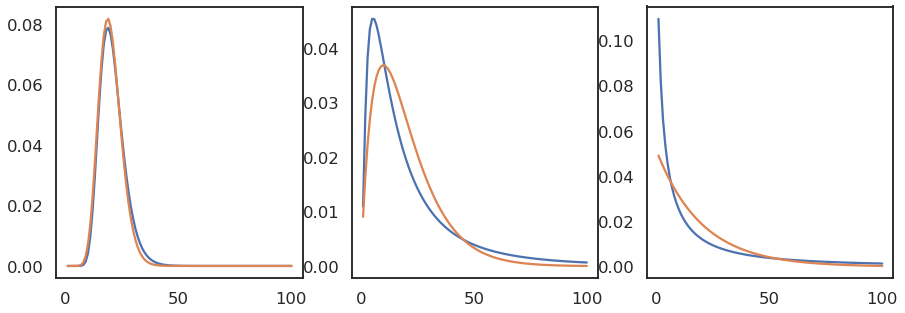

In [13]:
# compare log-normal distribution with gamma distribution

d = torch.arange(1., 101.)

mu = torch.tensor([3, 2.7, 2.5])
sig = torch.tensor([-2, .7, 2]).exp()
beta = torch.tensor([.8, .1, 1/20])
alpha = torch.tensor([20*.8, 2., 1.])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    p01 = torch.softmax(-(d.log()-mu[i])**2/sig[i] - d.log(), -1)
    p02 = torch.softmax(-beta[i]*d + (alpha[i] - 1)*d.log(), -1)
    print((d*p01).sum(), (d*p02).sum())
    
    axes[i].plot(d, p01)
    axes[i].plot(d, p02)

Here we will reproduce above average response patterns using behavioural models based on active inference agent embeded with explicit representation of duration. 

In [12]:
blocks = 1 # number of blocks
nsub = 100  # number of subjects
trials = 1000  # number of samples

from torch import zeros, ones, tensor

from befit.tasks import TempRevLearn
from befit.agents import BayesTempRevLearn
from befit.simulate import Simulator

reg_rewards = torch.from_numpy(Oreg).reshape(1, trials, 1, 2).repeat(1, 1, nsub, 1)
reg_rewards = ((reg_rewards + 1)/2).long()
irr_rewards = torch.from_numpy(Oirr).reshape(1, trials, 1, 2).repeat(1, 1, nsub, 1)
irr_rewards = ((irr_rewards + 1)/2).long()

reg_states = torch.from_numpy(Sreg).reshape(1, trials, 1).repeat(1, 1, nsub).long()
irr_states = torch.from_numpy(Sirr).reshape(1, trials, 1).repeat(1, 1, nsub).long()

offers = zeros(blocks, trials, nsub, dtype=torch.long)

reg_stimuli = {'states': reg_states, 
               'rewards': reg_rewards, 
               'offers': offers}

reg_temprev = TempRevLearn(reg_stimuli, nsub=nsub)

irr_stimuli = {'states': irr_states, 
               'rewards': irr_rewards, 
               'offers': offers}

irr_temprev = TempRevLearn(irr_stimuli, nsub=nsub)

# agents in condition with regular reversals
trans_pars = torch.stack([tensor([[16., .2, 2., -.25, 0., 0., 0.]]) + torch.randn(nsub//2, 7)*torch.tensor([.1, .1, .1, .1, .1, .1, .1]), 
                           tensor([[.5, -3, 2., -.25, 0., 0., 0.]]) + torch.randn(nsub//2, 7)*torch.tensor([.1, .1, .1, .1, .1, .1, .1])],
                         dim=0).reshape(-1, 7)

edhmm_agent1 = BayesTempRevLearn(runs=nsub, trials=trials)
edhmm_agent1.set_parameters(trans_pars)

sim1 = Simulator(reg_temprev, edhmm_agent1, runs=nsub, trials=trials)
sim1.simulate_experiment()
sim1.format_stimuli_and_responses();

edhmm_agent2 = BayesTempRevLearn(runs=nsub, trials=trials)
edhmm_agent2.set_parameters(trans_pars)

sim2 = Simulator(irr_temprev, edhmm_agent2, runs=nsub, trials=trials)
sim2.simulate_experiment()
sim2.format_stimuli_and_responses();

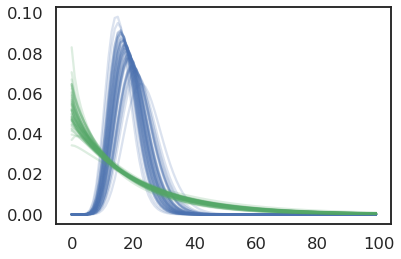

In [13]:
# plot priors over durations
d = torch.arange(1., edhmm_agent1.nd+1.)
plt.plot(edhmm_agent1.pd.numpy()[:nsub//2].T, 'b', alpha=.2);
plt.plot(edhmm_agent1.pd.numpy()[nsub//2:].T, 'g', alpha=.2);

In [14]:
res1 = sim1.responses
corrects1 = (reg_states == res1).float()  # correct responses in condition reg->irr
corrects1[res1 == 2] = np.nan
corrects1 = corrects1[0].numpy()

res2 = sim2.responses
corrects2 = (irr_states == res2).float()  # correct responses in condition irr->reg
corrects2[res2 == 2] = np.nan
corrects2 = corrects2[0].numpy()

responses1 = res1.float().numpy()[0]
responses2 = res2.float().numpy()[0]

In [15]:
ns = nsub//2

reg_res1 = responses1[..., :ns]
irr_res1 = responses1[..., ns:]
reg_corr1 = corrects1[..., :ns]
irr_corr1 = corrects1[..., ns:]

reg_perf1, reg_expl1 = get_reversal_statistics(reg_res1, reg_corr1, Sreg, ns)
irr_perf1, irr_expl1 = get_reversal_statistics(irr_res1, irr_corr1, Sreg, ns)

reg_res2 = responses2[..., :ns]
irr_res2 = responses2[..., ns:]
reg_corr2 = corrects2[..., :ns]
irr_corr2 = corrects2[..., ns:]
reg_perf2, reg_expl2 = get_reversal_statistics(reg_res2, reg_corr2, Sirr, ns)
irr_perf2, irr_expl2 = get_reversal_statistics(irr_res2, irr_corr2, Sirr, ns)

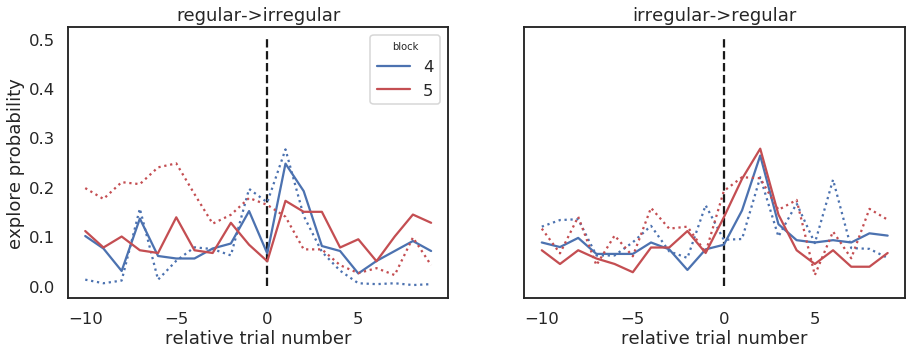

In [16]:
# plot superimposed behavioural and simulated response data
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
color = ['b', 'r']
for block in range(3,5):
    axes[0].plot(t, np.mean(np.vstack(reg_expl[block]), 0), label=block+1, color=color[block-3])
    axes[0].plot(t, np.mean(np.vstack(reg_expl1[block]), 0), ':', color=color[block-3])

    axes[1].plot(t, np.mean(np.vstack(irr_expl[block]), 0), color=color[block-3])
    axes[1].plot(t, np.mean(np.vstack(irr_expl2[block]), 0), ':', color=color[block-3])

axes[0].legend(title='block');
axes[0].vlines(0, 0., .5, 'k', linestyle='--');
axes[1].vlines(0, 0., .5, 'k', linestyle='--');
axes[0].set_xlabel('relative trial number');
axes[1].set_xlabel('relative trial number');
axes[0].set_title('regular->irregular');
axes[1].set_title('irregular->regular');
axes[0].set_ylabel('explore probability')
fig.savefig('explore_prob.svg', bbox_inches='tight', transparent=True, dpi=300)

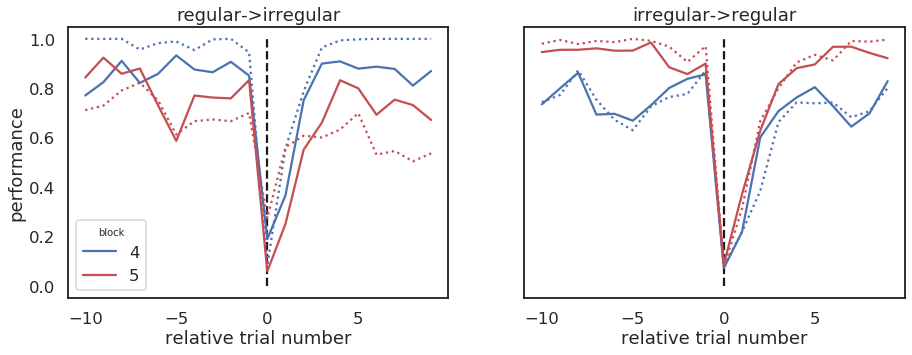

In [17]:
# plot superimposed behavioural and simulated response data
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
color = ['b', 'r']
for block in range(3,5):
    axes[0].plot(t, np.mean(np.vstack(reg_perf[block]), 0), label=block+1, color=color[block-3])
    axes[0].plot(t, np.mean(np.vstack(reg_perf1[block]), 0), ':', color=color[block-3])

    axes[1].plot(t, np.mean(np.vstack(irr_perf[block]), 0), color=color[block-3])
    axes[1].plot(t, np.mean(np.vstack(irr_perf2[block]), 0), ':', color=color[block-3])

axes[0].legend(title='block');
axes[0].vlines(0, 0., 1., 'k', linestyle='--');
axes[1].vlines(0, 0., 1., 'k', linestyle='--');
axes[0].set_xlabel('relative trial number');
axes[1].set_xlabel('relative trial number');
axes[0].set_title('regular->irregular');
axes[1].set_title('irregular->regular');
axes[0].set_ylabel('performance')
fig.savefig('performance_trial.svg', bbox_inches='tight', transparent=True, dpi=300)

In [20]:
reg_states.shape

torch.Size([1, 1000, 100])

In [26]:
# test influence of prior over context on belief evolution

edhmm_agent1.set_parameters()

T1 = 600
T2 = 800

reg_stimuli = {'states': reg_states[:, T1:T2], 
               'rewards': reg_rewards[:, T1:T2], 
               'offers': offers[:, T1:T2]}

reg_temprev = TempRevLearn(reg_stimuli, nsub=nsub)

irr_stimuli = {'states': irr_states[:, T1:T2], 
               'rewards': irr_rewards[:, T1:T2], 
               'offers': offers[:, T1:T2]}

irr_temprev = TempRevLearn(irr_stimuli, nsub=nsub)

beliefs = {'reg': [], 'irr': []}
for s0 in [-2., -1., 0., 1., 2.]:
    edhmm_agent1 = BayesTempRevLearn(runs=nsub, trials=200)
    edhmm_agent1.set_parameters(x=trans_pars, s0=s0)

    sim1 = Simulator(reg_temprev, edhmm_agent1, runs=nsub, trials=200)
    sim1.simulate_experiment()
    sim1.format_stimuli_and_responses();
    
    beliefs['reg'].append(torch.stack(edhmm_agent1.beliefs).sum(-1)[:-1])

    edhmm_agent2 = BayesTempRevLearn(runs=nsub, trials=200)
    edhmm_agent2.set_parameters(x=trans_pars, s0=s0)

    sim2 = Simulator(irr_temprev, edhmm_agent2, runs=nsub, trials=200)
    sim2.simulate_experiment()
    sim2.format_stimuli_and_responses();
    
    beliefs['irr'].append(torch.stack(edhmm_agent2.beliefs).sum(-1)[:-1])

(0, 50)

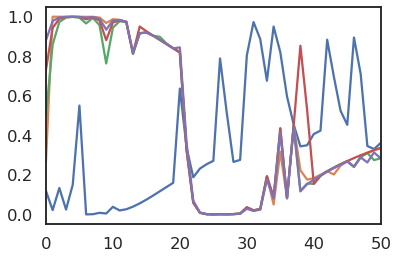

In [35]:
i = 0
sub = 10
plt.plot(torch.stack(beliefs['irr'])[..., sub, 0].numpy().T);
plt.xlim([0, 50])